<a href="https://colab.research.google.com/github/Brun0oO/Colab/blob/main/Prompt_based_Image_In_Painting_powered_by_ClipSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on the following notebook: https://github.com/amrrs/stable-diffusion-prompt-inpainting

In [3]:
! git clone https://github.com/timojl/clipseg 

Cloning into 'clipseg'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 200 (delta 47), reused 43 (delta 42), pack-reused 145
Receiving objects: 100% (200/200), 1.39 MiB | 19.44 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [4]:
! pip install diffusers -q

     |████████████████████████████████| 255 kB 5.0 MB/s 
     |████████████████████████████████| 163 kB 63.9 MB/s 


In [5]:
! pip install transformers -q -UU ftfy gradio  

     |████████████████████████████████| 5.3 MB 5.0 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 11.6 MB 39.2 MB/s 
     |████████████████████████████████| 7.6 MB 47.2 MB/s 
     |████████████████████████████████| 84 kB 3.0 MB/s 
     |████████████████████████████████| 84 kB 2.1 MB/s 
     |████████████████████████████████| 54 kB 850 kB/s 
     |████████████████████████████████| 2.3 MB 47.2 MB/s 
     |████████████████████████████████| 106 kB 77.9 MB/s 
     |████████████████████████████████| 56 kB 1.7 MB/s 
     |████████████████████████████████| 272 kB 66.8 MB/s 
     |████████████████████████████████| 55 kB 3.0 MB/s 
     |████████████████████████████████| 212 kB 75.9 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 80 kB 8.3 MB/s 
     |████████████████████████████████| 68 kB 7.7 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████

In [6]:
! pip install git+https://github.com/openai/CLIP.git -q

In [14]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [8]:
%cd clipseg

/content/clipseg


In [18]:
! ls

datasets	     metrics.py		      score.py
environment.yml      models		      setup.py
evaluation_utils.py  overview.png	      supplementary.pdf
example_image.jpg    Quickstart.ipynb	      Tables.ipynb
experiments	     README.md		      training.py
general_utils.py     sample_rd64.png	      Visual_Feature_Engineering.ipynb
LICENSE		     sample_rd64_refined.png


In [10]:
import torch
import requests
import cv2 
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

In [11]:
from io import BytesIO

from torch import autocast
import requests
import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline as StableDiffusionInpaintPipeline

In [15]:
! git lfs install

Updated git hooks.
Git LFS initialized.


In [16]:
# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();


In [19]:
! wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
! unzip -d weights -j weights.zip

--2022-10-27 08:02:11--  https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘weights.zip’

weights.zip             [     <=>            ]   9.68M  9.87MB/s    in 1.0s    

2022-10-27 08:02:13 (9.87 MB/s) - ‘weights.zip’ saved [10146905]

Archive:  weights.zip
 extracting: weights/rd16-uni.pth    
 extracting: weights/rd64-uni-refined.pth  
 extracting: weights/rd64-uni.pth    


In [20]:
# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load('/content/clipseg/weights/rd64-uni.pth', map_location=torch.device('cuda')), strict=False);


In [21]:
device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [22]:
# or load from URL...
image_url = 'https://okmagazine.ge/wp-content/uploads/2021/04/00-promo-rob-pattison-1024x1024.jpg' #'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimage.tmdb.org%2Ft%2Fp%2Foriginal%2F72xYNWRTVMDiKVa6SVu6EY0S9Np.jpg' #'https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png' 
input_image = Image.open(requests.get(image_url, stream=True).raw)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((512, 512)),
])
img = transform(input_image).unsqueeze(0)

In [23]:
!cd ..

In [24]:
input_image.convert("RGB").resize((512, 512)).save("init_image.png", "PNG")

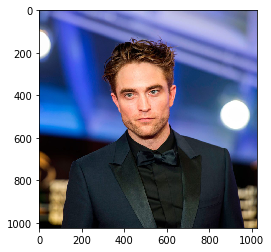

In [25]:
from matplotlib import pyplot as plt
plt.imshow(input_image, interpolation='nearest')
plt.show()

In [83]:
prompts = ['shirt']

In [84]:

# predict
with torch.no_grad():
    preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]


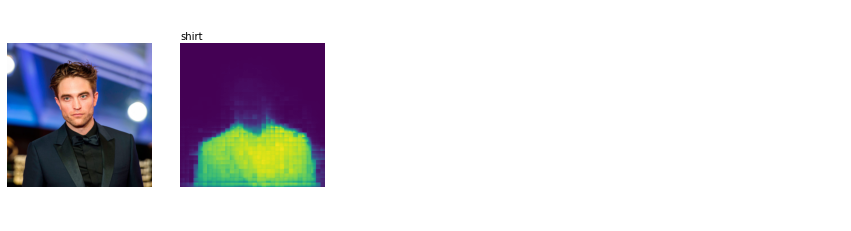

In [85]:
# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];

In [86]:
filename = f"mask.png"
plt.imsave(filename,torch.sigmoid(preds[0][0]))

In [87]:
img2 = cv2.imread(filename)

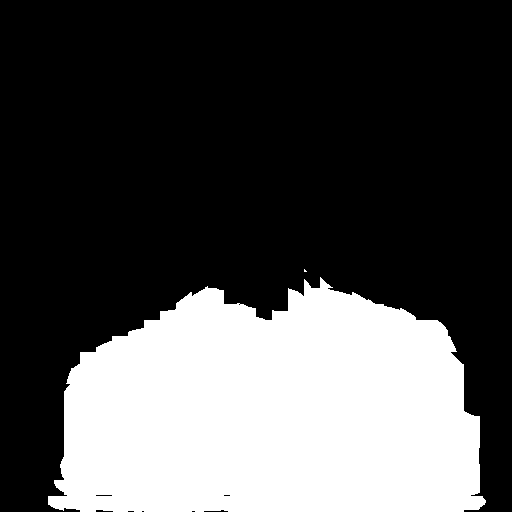

In [89]:
gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# For debugging only:
cv2.imwrite(filename,bw_image)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)

In [90]:
init_image = Image.open('init_image.png')
mask = Image.open('mask.png')

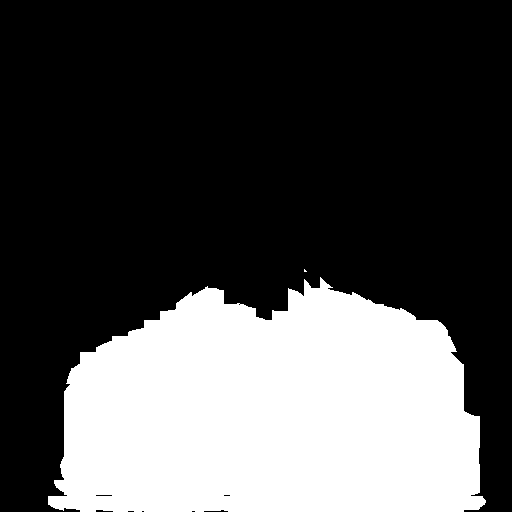

In [91]:
mask

In [94]:
with autocast("cuda"):
    images = pipe(prompt="a yellow flowered holiday shirt", init_image=init_image, mask_image=mask, strength=0.9)
  

0it [00:00, ?it/s]

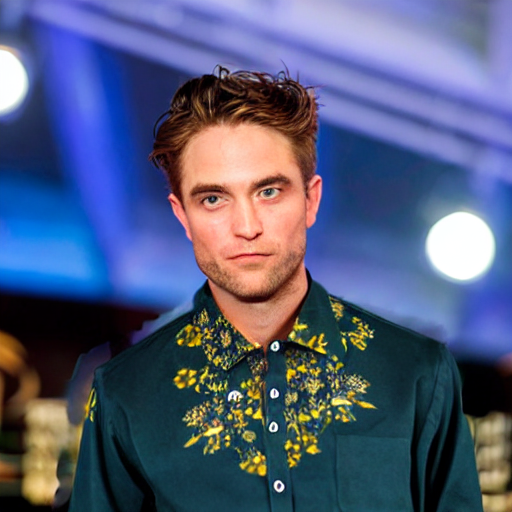

In [95]:
result=images['images'][0]
display(result)